# Image Captioning using Deep Learning: Assignment-3

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [74]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # # Set a fixed value for the hash seed
    #os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [75]:
import torchvision
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_path = './'

train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Your Code from here...

In [76]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train, [45000,5000])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [86]:
# load the data set

X_train,y_train=next(iter(train_loader))
X_val,y_val=next(iter(val_loader))
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library



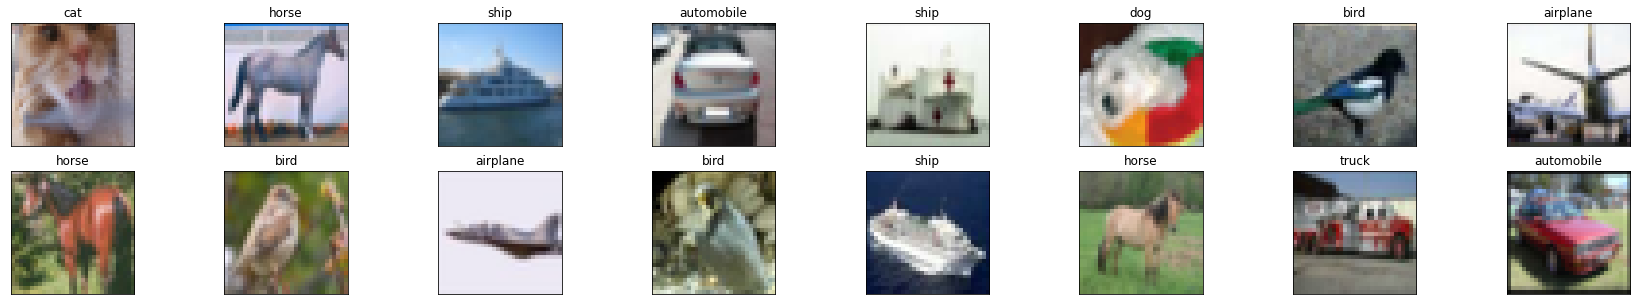

In [78]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
size=16
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,5))
for idx in range(size):
    ax=fig.add_subplot(2,size/2,idx+1,xticks=[],yticks=[])
    RGBshow(X_train[idx])
    ax.set_title(classes[y_train[idx]])

## Creating a Dataset Class


In [79]:
# define your dataset class
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label





## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [80]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
net = Net()


## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [81]:
def train(model, optimizer, criterion, train_loader,display_step=None):
    # loop over the dataset multiple times
    for epoch in range(10):
      for i,(images, labels) in enumerate(train_loader):
        # origin shape (4,3,32,32) = 4,3,1024
        # input_layer: 3 input channel, 6 output channel, 5 kernal size
        outputs = model(images)
        loss = criterion(outputs, labels)
        # backward prop.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Finished Training')


## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [82]:
def predict(model, X_test):
  with torch.no_grad():
    y_pred_tensor=torch.argmax(model(X_test), axis=1)
    return y_pred_tensor.numpy()
  

In [83]:
def accuracy(pred, labels):
  correct = 0
  for i in range(len(pred)):
    if pred[i]==labels[i]:
      correct=correct+1
    else:
      correct=correct+0
    accu = correct/len(pred)
    return accu
  

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [84]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train(net, optimizer, criterion, train_loader,display_step=None)

Finished Training


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [85]:
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        x, y = data
        output = net(x)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')

accuracy: 0.727


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_3.pt``` model-weights file to the repository.

In [88]:
from google.colab import files
torch.save(net, 'ass_3.pt')
files.download('ass_3.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [87]:
# load the model, use predict function
predict(net,X_val)



array([7, 9, 1, 3, 7, 9, 2, 1, 8, 8, 9, 3, 6, 7, 2, 8, 5, 2, 6, 0, 8, 6,
       6, 1, 4, 3, 4, 9, 4, 9, 3, 3, 1, 5, 1, 6, 3, 0, 5, 5, 5, 9, 1, 8,
       1, 1, 5, 3, 4, 9, 7, 5, 4, 4, 7, 4, 9, 4, 4, 1, 7, 3, 7, 8])